In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url

import tqdm
import os
import pandas as pd
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt

# read model

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cd gdrive/MyDrive && ls

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_state_dict = torch.load('gdrive/MyDrive/vgg16_trained_acc_70')
model = models.vgg16_bn()

model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 200)

model.load_state_dict(loaded_state_dict)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Dataset

In [3]:
# found this in: https://github.com/TDeVries/cub2011_dataset/blob/master/cub2011.py
class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, loader=default_loader, download=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        overlaps = self._get_overlaps()
        if overlaps is not None:
            images['image_name'] = images['filepath'].str.split("/").str[-1]
            overlaps = overlaps.merge(images, left_on='cub_name', right_on='image_name')
            overlaps['is_training_img'] = 1
            train_test_split.update(overlaps)


        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def _get_overlaps(self):
        try:
            download_url('https://gist.githubusercontent.com/arunmallya/a6889f151483dcb348fa70523cb4f578/raw/1ae0992b71375f63bd3779ac41eff4455918a6a8/matches.txt',
                         root=self.root,
                         filename='overlaps.txt')
            return pd.read_csv(os.path.join(self.root, 'overlaps.txt'),
                                    sep=' -> ', names=['cub_name', 'imagenet_name'])
        except Exception:
            return None




    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

# 3. Box proposals

In [4]:
def sliding_window(image: np.ndarray, step_size=50, window_size=(230, 230)):
    rect_list = []
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            rect_list.append((x, y, x + window_size[0], y + window_size[1]))
    return rect_list

In [5]:
def selective_search(image: np.ndarray, min_size=100, max_size=400):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)

    #ss.switchToSelectiveSearchQuality() # it is slower and return more boxes
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    filtered_rects = [(x, y, x + w, y + h) for (x, y, w, h) in rects if min_size <= w <= max_size and min_size <= h <= max_size]
    return filtered_rects


In [6]:
url = "https://github.com/opencv/opencv_extra/raw/master/testdata/cv/ximgproc/model.yml.gz"
destination_path = "model.yml.gz"

response = requests.get(url, stream=True)
with open(destination_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=128):
        file.write(chunk)

def generate_edgeboxes(image: np.ndarray,  min_size=100, max_size=400):

    edge_detection = cv2.ximgproc.createStructuredEdgeDetection("model.yml.gz")
    edges = edge_detection.detectEdges(np.float32(image) / 255.0)

    orimap = edge_detection.computeOrientation(edges)
    edges = edge_detection.edgesNms(edges, orimap)

    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(30)
    boxes,score = edge_boxes.getBoundingBoxes(edges, orimap)
    filtered_rects = [(x, y, x + w, y + h) for (x, y, w, h) in boxes if min_size <= w <= max_size and min_size <= h <= max_size]
    return filtered_rects

## Test box proposals

In [7]:
def boxes_heatmap(image: np.ndarray, rect_list):
    boxes_mask = np.zeros_like(image)
    beta = 1/(len(rect_list)+1)
    for (x, y, x2, y2) in rect_list:
        box = np.zeros_like(image)
        cv2.rectangle(box, (x, y), (x2, y2), (0, 255, 0), -1)
        boxes_mask = cv2.addWeighted(boxes_mask, 1., box, beta, 0.)
    return boxes_mask
    #return cv2.add(image.copy(), boxes_mask)

def boxes_borders(image: np.ndarray, rect_list):
    out = image.copy()
    for (x, y, x2, y2) in rect_list:
        cv2.rectangle(out, (x, y), (x2, y2), (0, 255, 0), 1)
    return out

def plot_box_proposals(image: np.ndarray, rect_list):
    fig, ax = plt.subplots()
    fig.set_figwidth(15)

    ax1 = plt.subplot(1, 2, 1)
    borders = boxes_borders(image, rect_list)
    ax1.imshow(borders)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    ax2 = plt.subplot(1, 2, 2)
    heat_map = boxes_heatmap(image, rect_list)
    ax2.imshow(heat_map)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

In [8]:
data_set = Cub2011(os.path.abspath("./data"), train=True)
images = [ np.array(data_set.__getitem__(i)[0]) for i in np.random.choice(data_set.__len__(), 5) ]

Using downloaded and verified file: d:\classes\deep-learning-23-project\data\overlaps.txt


C:\Users\mrgaw\AppData\Local\Temp\ipykernel_11488\2639987832.py:75: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(os.path.join(self.root, 'overlaps.txt'),


Files already downloaded and verified
Using downloaded and verified file: d:\classes\deep-learning-23-project\data\overlaps.txt


C:\Users\mrgaw\AppData\Local\Temp\ipykernel_11488\2639987832.py:75: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(os.path.join(self.root, 'overlaps.txt'),


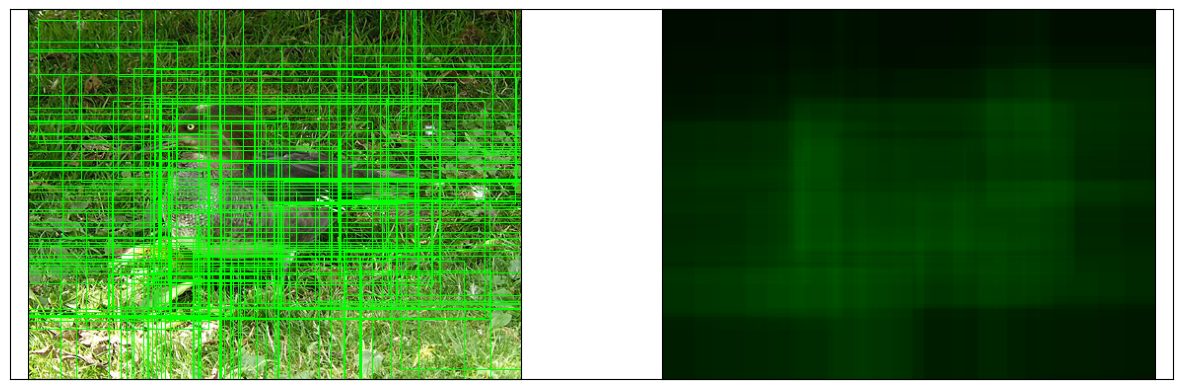

229


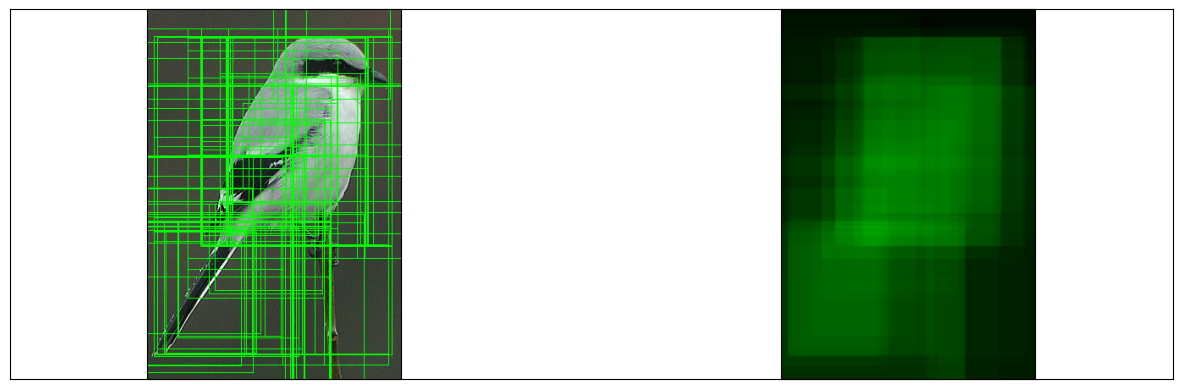

122


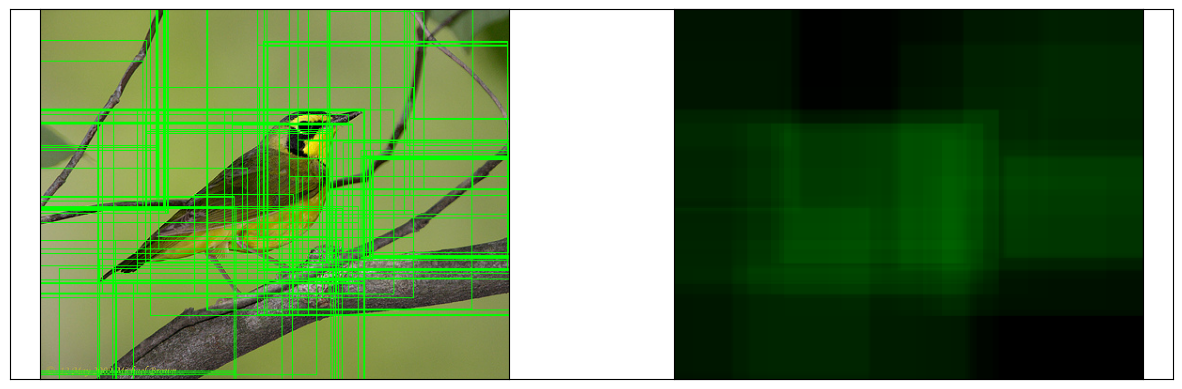

188


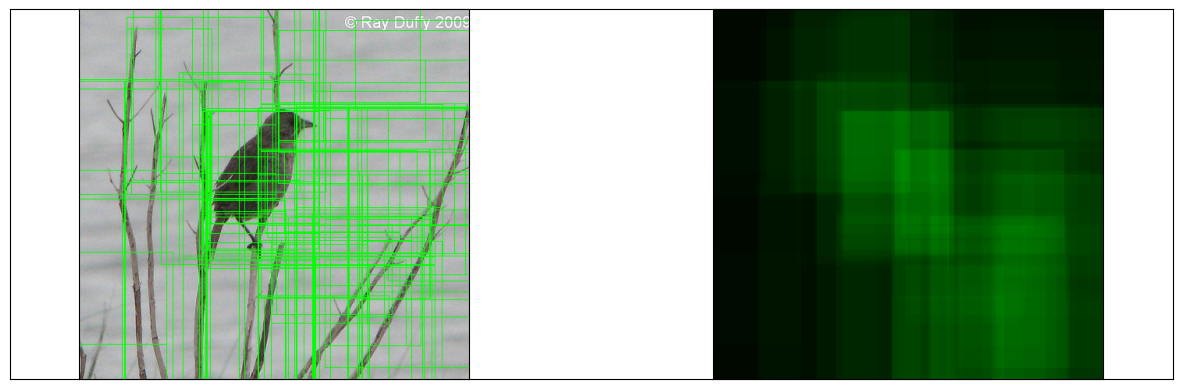

164


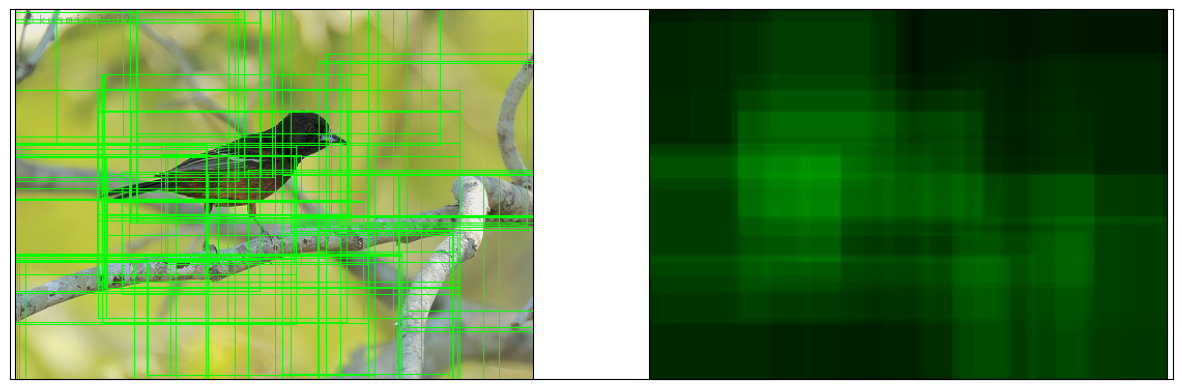

148


In [9]:
for img in images:
    rect_list = selective_search(img)
    plot_box_proposals(img, rect_list)
    print(len(rect_list))

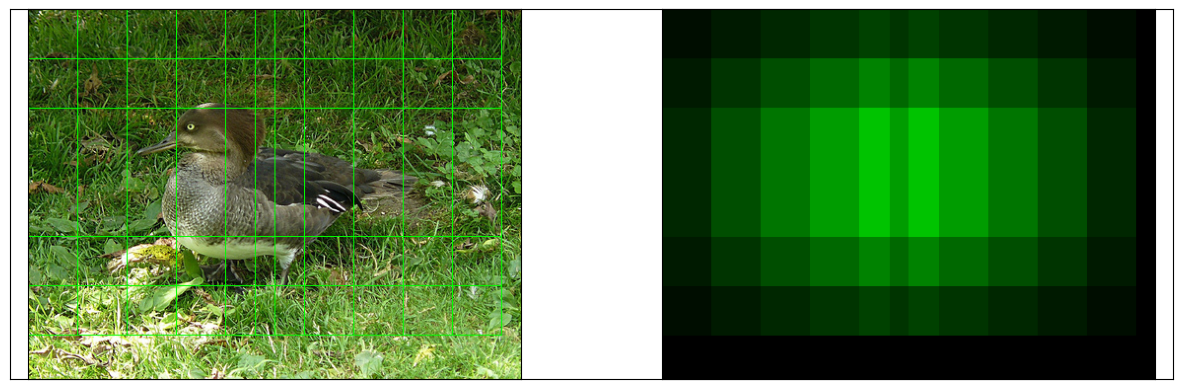

18


In [10]:
rect_list = sliding_window(images[0], step_size=50, window_size=(230, 230))
plot_box_proposals(images[0], rect_list)
print(len(rect_list))

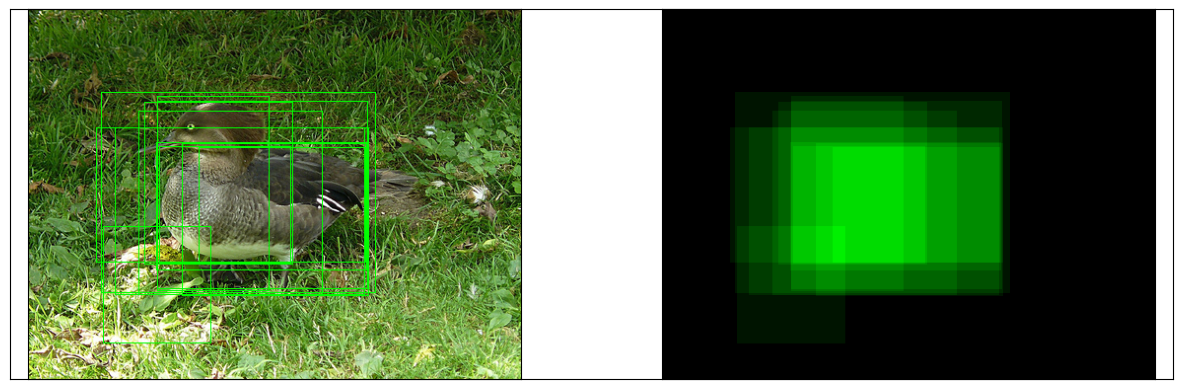

12


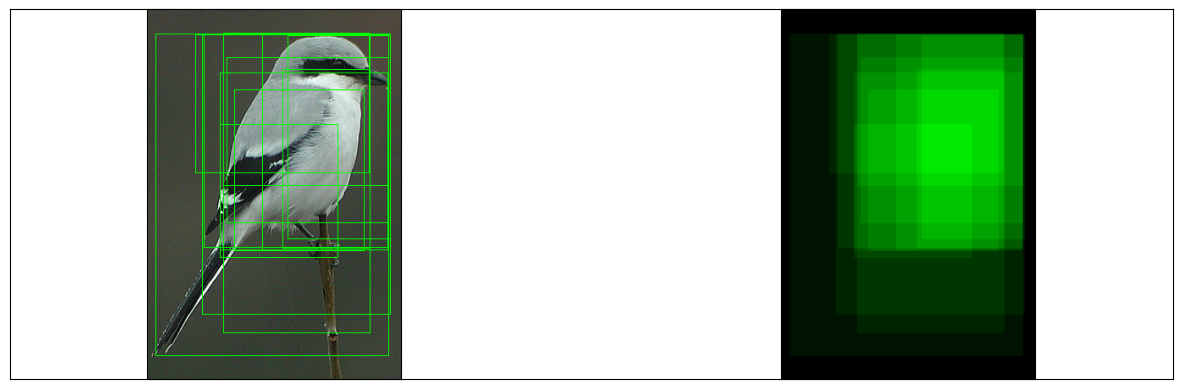

13


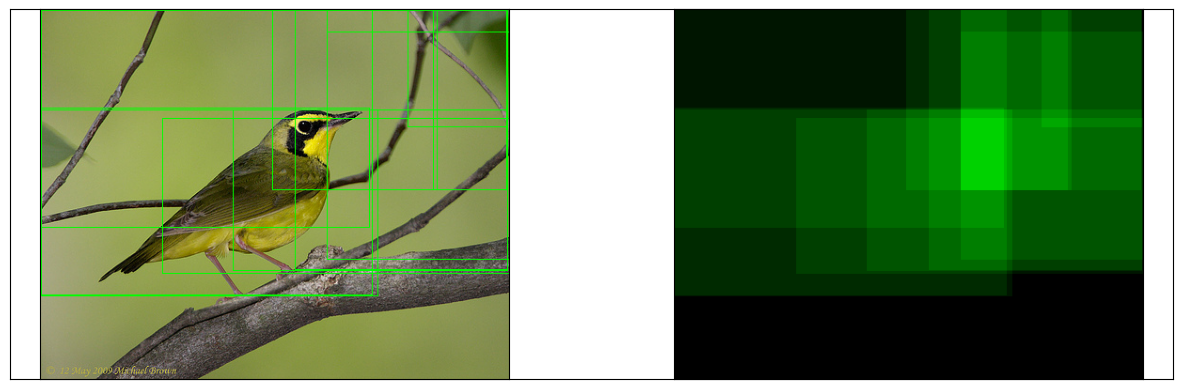

11


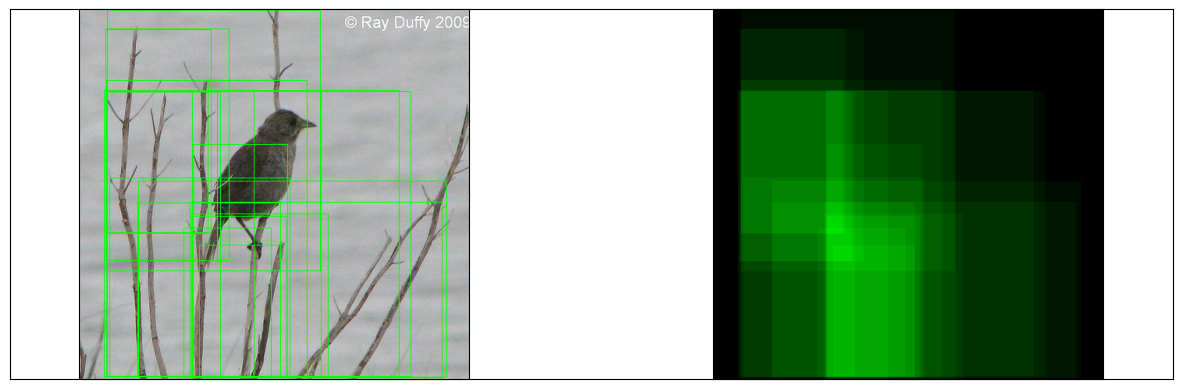

20


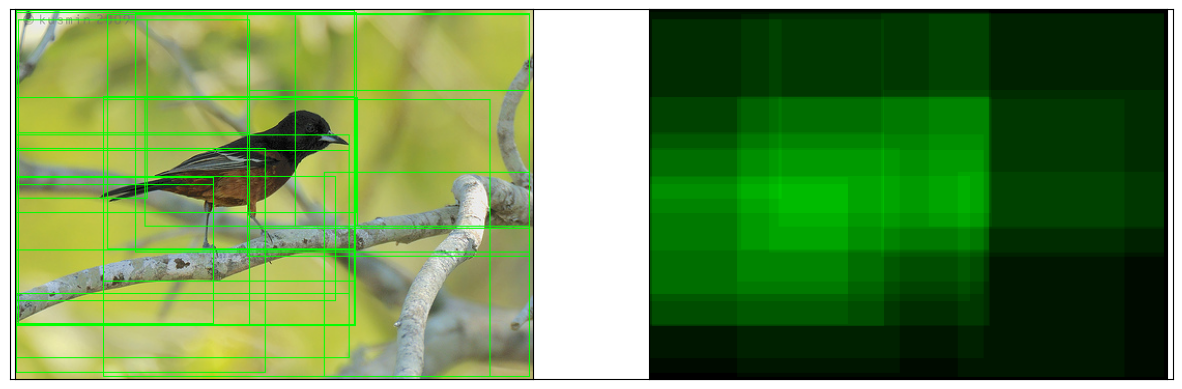

22


In [11]:
for img in images:
    rect_list = generate_edgeboxes(img)
    plot_box_proposals(img, rect_list)
    print(len(rect_list))

# localization dataset

In [17]:
!pwd

/content


In [18]:
!cd /content/data/CUB_200_2011 && ls

attributes	    classes.txt		    images	parts	train_test_split.txt
bounding_boxes.txt  image_class_labels.txt  images.txt	README


In [19]:
root = "./data/CUB_200_2011"

df_filepath = pd.read_csv(f'{root}/images.txt', sep=' ', names=['img_id', 'filepath'])
df_target = pd.read_csv(f'{root}/image_class_labels.txt', sep=' ', names=['img_id', 'label'])
df_bounding_box = pd.read_csv(f'{root}/bounding_boxes.txt', sep=' ', names=['img_id', 'x1', "y1", "x2", "y2"])
train_test_split = pd.read_csv(os.path.join(f'{root}/train_test_split.txt'), sep=' ', names=['img_id', 'is_training_img'])


In [20]:
df_merged = pd.merge(df_filepath, df_target, on='img_id')
df_merged = pd.merge(df_merged, df_bounding_box, on='img_id')
df_merged = pd.merge(df_merged, train_test_split, on='img_id')
df_merged

img_id                                           filepath  label  \
0           1  001.Black_footed_Albatross/Black_Footed_Albatr...      1   
1           2  001.Black_footed_Albatross/Black_Footed_Albatr...      1   
2           3  001.Black_footed_Albatross/Black_Footed_Albatr...      1   
3           4  001.Black_footed_Albatross/Black_Footed_Albatr...      1   
4           5  001.Black_footed_Albatross/Black_Footed_Albatr...      1   
...       ...                                                ...    ...   
11783   11784  200.Common_Yellowthroat/Common_Yellowthroat_00...    200   
11784   11785  200.Common_Yellowthroat/Common_Yellowthroat_00...    200   
11785   11786  200.Common_Yellowthroat/Common_Yellowthroat_00...    200   
11786   11787  200.Common_Yellowthroat/Common_Yellowthroat_00...    200   
11787   11788  200.Common_Yellowthroat/Common_Yellowthroat_00...    200   

          x1     y1     x2     y2  is_training_img  
0       60.0   27.0  325.0  304.0                0  
1      139.0   30.0  153.0  264.0                1  
2       14.0  112.0  388.0  186.0                0  
3      112.0   90.0  255.0  242.0                1  
4       70.0   50.0  134.0  303.0                1  
...      ...    ...    ...    ...              ...  
11783   89.0   95.0  354.0  250.0                1  
11784  157.0   62.0  184.0  219.0                0  
11785  190.0  102.0  198.0  202.0                0  
11786    3.0   20.0  408.0  307.0                1  
11787   20.0  113.0  177.0  263.0                0  

[11788 rows x 8 columns]

In [21]:
list_from_dataframe = df_merged.values.tolist()

In [22]:
list_from_dataframe[0]

[1,
 '001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg',
 1,
 60.0,
 27.0,
 325.0,
 304.0,
 0]

In [24]:

data_points = []

for it in list_from_dataframe:
    img = default_loader(f"{root}/images/{it[1]}")
    #img = cv2.imread(f"{root}/images/{it[1]}")
    label = it[2]
    bounding_box = (it[3], it[4], it[5], it[6])
    is_training_img = it[7]
    data_points.append((img, label, bounding_box, is_training_img))



In [25]:
import torchvision.transforms as transforms

base_transform = models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()


def predict_one_image(model, image):
    model.eval()

    with torch.no_grad():
        input = base_transform(image)
        input = input.unsqueeze(0)
        input = input.to(device)

        output = model(input)

        value, predicted = torch.max(output, 1)
        predicted += 1  # label from 1, index from 0

    return value, predicted

In [20]:
# test model again
count, correct_count = 0, 0
for (image, label, box, is_training_img) in tqdm(data_points):
    if is_training_img:
        continue
    count += 1
    if predict_one_image(model, image)[1] == label:
        correct_count += 1
print(correct_count, count)
print("acc: ", correct_count/count)

100%|██████████| 11788/11788 [01:25<00:00, 137.46it/s]

4068 5794
acc:  0.7021056265101829


In [21]:
# test model again in training set
count, correct_count = 0, 0
for (image, label, box, is_training_img) in tqdm(data_points):
    if not is_training_img:
        continue
    count += 1
    if predict_one_image(model, image)[1] == label:
        correct_count += 1
print(correct_count, count)
print("acc: ", correct_count/count) # #OVERFIT

100%|██████████| 11788/11788 [01:21<00:00, 144.96it/s]

5734 5994
acc:  0.9566232899566233


# to localization model

In [26]:
import PIL

def to_sub_images(image: PIL.Image.Image, rect_list):
    cropped_image_list = [image.crop((x1, y1, x2, y2)) for (x1, y1, x2, y2) in rect_list]
    return cropped_image_list


In [27]:
index = 123
image: PIL.Image.Image = data_points[123][0]
label = data_points[123][1]

rect_list = generate_edgeboxes(np.array(image))
cropped_image_list = to_sub_images(image, rect_list)
predict_label = predict_one_image(model, image)

In [28]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

print(bb_intersection_over_union((0,0,4,4), (2,2,6,6)))

0.21951219512195122


In [29]:
def compute_localization_one_image(image: PIL.Image.Image, model, label, box_method="sliding_window"):
    if box_method == "sliding_window":
        rect_list = sliding_window(np.array(image))
    if box_method == "edge_boxes":
        rect_list = generate_edgeboxes(np.array(image))
    if box_method == "selective_search":
        rect_list = selective_search(np.array(image))
    if len(rect_list) == 0:
        return (0,0,0,0)

    cropped_image_list = to_sub_images(image, rect_list)
    predict_label = predict_one_image(model, image)
    cropped_value_label = []
    for cropped_image in cropped_image_list:
        cropped_value_label.append(predict_one_image(model, cropped_image))
    index = -1
    max_value = 0.0
    for i, (value, predict_label) in enumerate(cropped_value_label):
        if predict_label != label:
            continue
        if value > max_value:
            index = i
            max_value = value

    return rect_list[index]

In [31]:
count = 0
label_correct_count = 0
box_correct_count = 0
threshold = 0.5
limit_count = 200
box_method = "selective_search" # edge_boxes, sliding_window, selective_search
from tqdm import tqdm

for (image, label, box, is_training) in tqdm(data_points[:limit_count]):
    # train and test set should have different performence, do not mix them
    if not is_training: # training
        continue
    count += 1
    if predict_one_image(model, image)[1] != label:
        continue
    label_correct_count += 1
    predict_box = compute_localization_one_image(image, model, label, box_method)
    if bb_intersection_over_union(predict_box, box) < threshold:
        continue
    box_correct_count += 1

print(count, label_correct_count, box_correct_count) # all methods are not so good now

100%|██████████| 200/200 [06:21<00:00,  1.91s/it]

100 89 21


In [32]:
21/89

0.23595505617977527

1. not vweified, maybe some bugs here.
2.